In [1]:
import os.path as osp
import os
import argparse

import networkx as nx
from torch_geometric.utils.convert import to_networkx
import matplotlib.pyplot as plt

import torch
import torch.nn.functional as F
from torch_geometric.datasets import Planetoid
import torch_geometric.transforms as T
from torch_geometric.nn import GCNConv, ChebConv, graclus
from torch_geometric.nn import max_pool

from torch_geometric.transforms import Compose,  RemoveIsolatedNodes

dataset = 'Cora'
path = osp.join(os.getcwd(), 'data', dataset)
dataset = Planetoid(path, dataset, T.NormalizeFeatures())
data = dataset[0]
data.batch = None


### Define model
Here we define a simple graph convolutional neural network model. In the _init_ part, we define/initialize the different layers and in the _forward_ part, we chain the different layer together (in the correct order). During training, we will simply call the forward part. 

In [2]:
class GCN(torch.nn.Module):
    def __init__(self):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(dataset.num_features, 16, cached=True) # a conv layer
        self.conv2 = GCNConv(16, dataset.num_classes, cached=True) # another conv layer

        self.reg_params = self.conv1.parameters()
        self.non_reg_params = self.conv2.parameters()

    def forward(self):
        x, edge_index, edge_weight = data.x, data.edge_index, data.edge_attr # unpack the data container
        
        x = F.relu(self.conv1(x, edge_index, edge_weight)) 
        x = F.dropout(x, training=self.training)
        x = self.conv2(x, edge_index, edge_weight)
        
        return F.log_softmax(x, dim=1)

### Define test and train functions
Usually we would define a training / testing loop but as we are only training on a single graph every epoch is only 1 iteration. Test and training set are defined via masks, that oclude parts of the graph.

In [3]:
def train():
    model.train()
    optimizer.zero_grad()
    
    training_output = model()[data.train_mask]
    loss = F.nll_loss(training_output, data.y[data.train_mask])
    loss.backward() # this does backpropagation
    #F.nll_loss(model()[data.train_mask], data.y[data.train_mask]).backward()
    optimizer.step()

In [4]:
def test():
    model.eval()
    logits, accs = model(), []
    for _, mask in data('train_mask', 'val_mask', 'test_mask'):
        pred = logits[mask].max(1)[1]
        acc = pred.eq(data.y[mask]).sum().item() / mask.sum().item()
        accs.append(acc)
    return accs

### Initialize model

In [5]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = GCN().to(device)
data = data.to(device)
optimizer = torch.optim.Adam([
    dict(params=model.reg_params, weight_decay=5e-4),
    dict(params=model.non_reg_params, weight_decay=0)
], lr=0.01)

### execute training

In [6]:
best_val_acc = test_acc = 0
for epoch in range(1, 100):
    train()
    train_acc, val_acc, tmp_test_acc = test()
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        test_acc = tmp_test_acc
    log = 'Epoch: {:03d}, Train: {:.4f}, Val: {:.4f}, Test: {:.4f}'
    print(log.format(epoch, train_acc, best_val_acc, test_acc))

Epoch: 001, Train: 0.2143, Val: 0.1580, Test: 0.1590
Epoch: 002, Train: 0.4214, Val: 0.2460, Test: 0.2320
Epoch: 003, Train: 0.7214, Val: 0.5240, Test: 0.5400
Epoch: 004, Train: 0.7286, Val: 0.5440, Test: 0.5510
Epoch: 005, Train: 0.7429, Val: 0.5440, Test: 0.5510
Epoch: 006, Train: 0.7214, Val: 0.5440, Test: 0.5510
Epoch: 007, Train: 0.7714, Val: 0.5440, Test: 0.5510
Epoch: 008, Train: 0.8286, Val: 0.5440, Test: 0.5510
Epoch: 009, Train: 0.8643, Val: 0.5440, Test: 0.5510
Epoch: 010, Train: 0.8786, Val: 0.5700, Test: 0.5870
Epoch: 011, Train: 0.8786, Val: 0.5700, Test: 0.5870
Epoch: 012, Train: 0.8857, Val: 0.5740, Test: 0.5920
Epoch: 013, Train: 0.8857, Val: 0.5780, Test: 0.5910
Epoch: 014, Train: 0.9000, Val: 0.5960, Test: 0.6010
Epoch: 015, Train: 0.9214, Val: 0.6060, Test: 0.6290
Epoch: 016, Train: 0.9214, Val: 0.6320, Test: 0.6370
Epoch: 017, Train: 0.9286, Val: 0.6380, Test: 0.6460
Epoch: 018, Train: 0.9214, Val: 0.6520, Test: 0.6630
Epoch: 019, Train: 0.9286, Val: 0.6620, Test: 

## Pooling example
#### Create a function to visualize a graph and then plot the cora dataset

In [7]:
def draw_graph(G, node_labels=None):
    # delete unconnected parts (it is a partial dataset...)
    largest_component = max(nx.weakly_connected_components(G), key=len)
    G = G.subgraph(largest_component)
    plt.figure(1,figsize=(7,6))
    nx.draw(G, node_size=25, linewidths=6)
    plt.title('Number of Nodes ' + str(len(G)))
    plt.show()

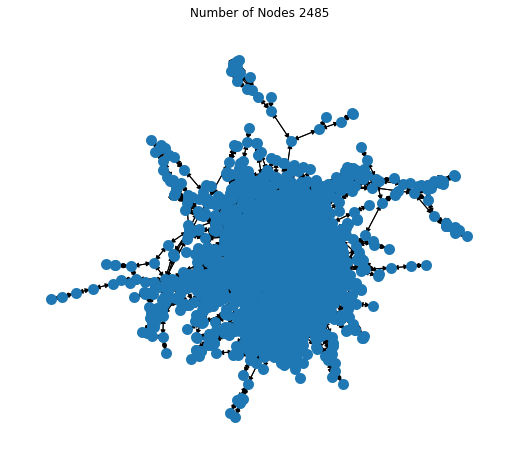

In [8]:
cora_graph = to_networkx(data)
#node_labels = data.y.cpu()[list(cora_graph.nodes)].numpy()
draw_graph(cora_graph)


Simple pooling contains two parts: Graph clustering and the actual pooling
One preimplemented clustering algorithm is graculus (some algorithm, I didn't knew it either...)

In [9]:
clustering1 = graclus(data.edge_index)

The clustering is just a list that assigns a cluster to every node

In [10]:
print(clustering1)

tensor([   0,    1,    2,  ...,  287, 1473,  165], device='cuda:0')


Pytorch-geometric (the graph conv. net library) has this data container class that holds all information about the graph.

In [11]:
print(data)

Data(edge_index=[2, 10556], test_mask=[2708], train_mask=[2708], val_mask=[2708], x=[2708, 1433], y=[2708])


once we have the clustering, we can use standard pooling methods. For example max-pooling. Using this approach, every cluster will be represented via 1 resulting node that gets the max of the feature vectors as its new feature vector

In [12]:
pooled1 = max_pool(clustering1, data)

We can draw the result again, note that with graculus (with default parameters) the number of nodes is reduced by ruffly 1/3 in every iteration
(drawing the graph takes a lot of time)


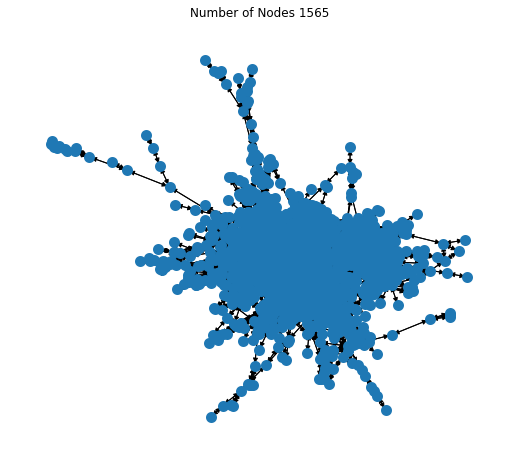

In [13]:
draw_graph(to_networkx(pooled1))

Now we redo the clustering/pooling step several times to monitor the difference

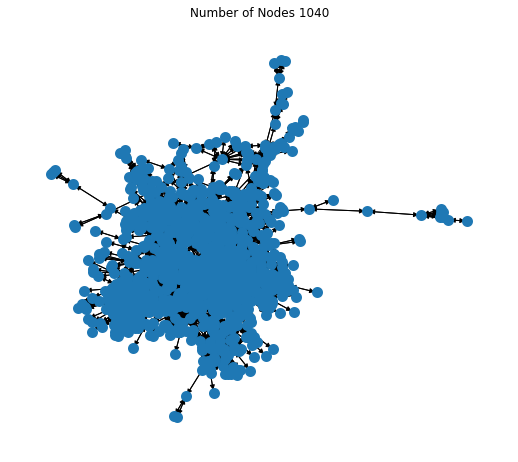

In [14]:
clustering2 = graclus(pooled1.edge_index)
pooled2 = max_pool(clustering2, pooled1)
draw_graph(to_networkx(pooled2))

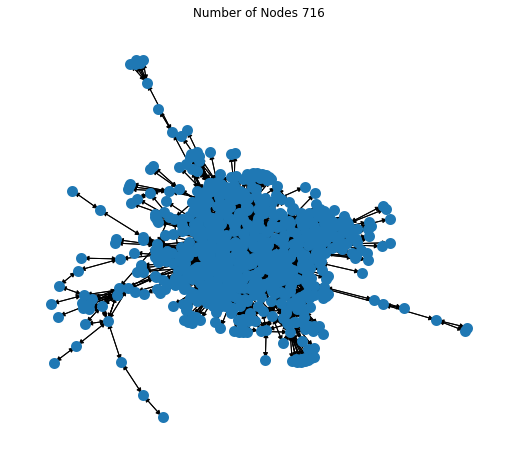

In [15]:
clustering3 = graclus(pooled2.edge_index)
pooled3 = max_pool(clustering3, pooled2)
draw_graph(to_networkx(pooled3))

And so on...
At some point it always breaks and has dimension problems but I don't know why ¯\_(ツ)_/¯

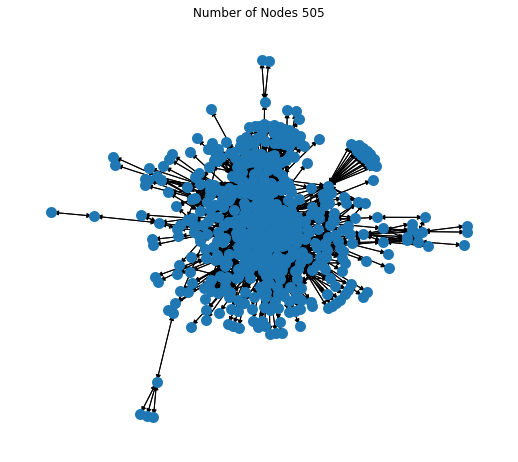

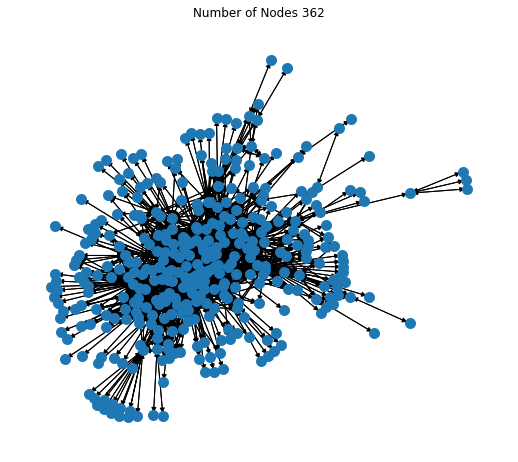

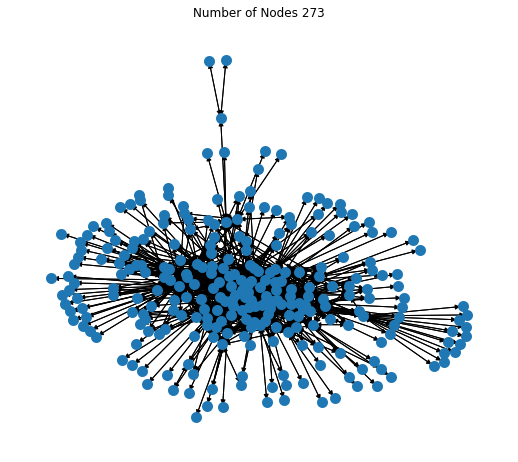

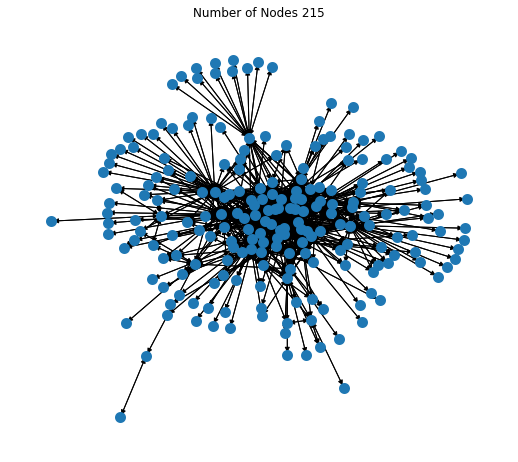

RuntimeError: shape '[293, 1]' is invalid for input of size 288

In [17]:
pooled = pooled3
for i in range(10):
    clustering = graclus(pooled.edge_index)
    pooled = max_pool(clustering, pooled)
    draw_graph(to_networkx(pooled))